In [49]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from utils import * 
import src.download as download
import src.tools as tools
from src import get_genome_id
import glob
from tqdm import tqdm
from src.reference import compare, annotate
from utils import *


%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# This is the genome metadata for all NCBI reference genomes. 
ncbi_genome_metadata_df = load_ncbi_genome_metadata(genome_metadata_path='../data/dataset/ncbi_genome_metadata.tsv', taxonomy_metadata_path='../data/dataset/ncbi_taxonomy_metadata.tsv') 

phyla_in_dataset = pd.read_csv('../data/dataset/dataset.csv', index_col=0, usecols=['id', 'lineage']).lineage
phyla_in_dataset = np.unique([lineage.split(';')[1] for lineage in phyla_in_dataset[phyla_in_dataset.str.contains(';')]])
phyla_in_dataset = np.unique([phylum for phylum in phyla_in_dataset if (phylum != 'environmental samples')])

print(len(phyla_in_dataset), 'phyla in the dataset.')
print(ncbi_genome_metadata_df.phylum.nunique(), 'phyla with NCBI reference genomes.')

genome_metadata_df = ncbi_genome_metadata_df[~ncbi_genome_metadata_df.phylum.isin(phyla_in_dataset)].copy()
genome_metadata_df = genome_metadata_df.sort_values('checkm_completeness', ascending=False)
genome_metadata_df = genome_metadata_df.drop_duplicates('phylum', keep='first')

83 phyla in the dataset.
56 phyla with NCBI reference genomes.


In [13]:
ncbi = download.ncbi.NCBI()
ncbi.get_genomes(genome_metadata_df.index, include=['gbff', 'genome'], dirs={'genome':'../data/ncbi/genomes', 'gbff':'../data/ncbi/gbffs'})
ncbi.cleanup()

NCBI.get_genomes: Downloading data for GCF_021057185.1.: 100%|██████████| 20/20 [00:00<00:00, 1430.92it/s]


In [14]:
prodigal = tools.Prodigal()
for input_path in tqdm(glob.glob('../data/ncbi/genomes/*'), desc='Running Prodigal on genomes for rare taxa.'):
    output_path = f'../data/prodigal/{get_genome_id(input_path)}_protein.faa'
    if not os.path.exists(output_path):
        prodigal.run(input_path, output_path=output_path)

interproscan = tools.InterProScan()
for input_path in tqdm(glob.glob('../data/prodigal/*'), desc='Running InterProScan on Prodigal predictions for rare taxa.'):
    output_path = f'../data/interpro/{get_genome_id(input_path)}_annotation.tsv'
    if not os.path.exists(output_path):
        interproscan.run(input_path, output_path)

# Prodigal sometimes predicts a string of X amino acids (unknown), which coincide with assembly gaps. The
# matching proteins are generally marked as partial in the NCBI reference. Need to figure out a way to handle this. 

Running Prodigal on genomes for rare taxa.:   0%|          | 0/20 [00:00<?, ?it/s]

Running Prodigal on genomes for rare taxa.: 100%|██████████| 20/20 [00:00<00:00, 66629.13it/s]
Running InterProScan on Prodigal predictions for rare taxa.: 100%|██████████| 20/20 [00:00<00:00, 60963.72it/s]


In [15]:
if not os.path.exists('../data/results/results-2/dataset.csv'):
    top_hits_df, all_hits_df = list(), list()
    for query_path in tqdm(glob.glob('../data/prodigal/*'), desc='Comparing Prodigal predictions with NCBI reference annotations.'):
        reference_path = f'../data/ncbi/gbffs/{get_genome_id(query_path)}_genomic.gbff'
        top_hits_df_, all_hits_df_ = compare(query_path, reference_path)
        top_hits_df += [top_hits_df_]
        all_hits_df += [all_hits_df_]
    top_hits_df = pd.concat(top_hits_df)
    all_hits_df = pd.concat(all_hits_df)
    all_hits_df.to_csv('../data/results/results-2/all_hits.csv')

    dataset_df = top_hits_df.merge(genome_metadata_df, left_on='genome_id', right_index=True)
    dataset_df = dataset_df.rename(columns={'query_seq':'seq'})
    dataset_df = dataset_df[dataset_df.seq.apply(len) < 2000].copy()
    dataset_df.to_csv('../data/results/results-2/dataset.csv')
else:
    dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
    all_hits_df = pd.read_csv('../data/results/results-2/all_hits.csv', index_col=0)


dataset_df = annotate(dataset_df)
all_hits_df = annotate(all_hits_df, prefix='subject')

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

# Because I did not use a minimum overlap length, want to make sure there are no unreasonably short matches. Minimum overlap length is 84, so seems to be OK.
# dataset_df[dataset_df.match].overlap_length.min()


In [16]:
# Out of curiosity, want to see how many of the conflicting reference sequences the model predicts to be real or spurious.
# Will look at both the matched sequences and the conflicting sequences. 

top_hit_metadata_df = dataset_df[dataset_df.match | is_cds_conflict(dataset_df)].copy()
top_hit_metadata_df['prodigal_id'] = top_hit_metadata_df.index 
top_hit_metadata_df = top_hit_metadata_df.set_index('top_hit_protein_id')
top_hit_metadata_df = top_hit_metadata_df[[col for col in top_hit_metadata_df.columns if 'top_hit' in col] + ['category']]
top_hit_metadata_df.index.name = 'id'
top_hit_metadata_df = top_hit_metadata_df.rename(columns={col:col.replace('top_hit_', '') for col in top_hit_metadata_df.columns})
top_hit_metadata_df.to_csv('../data/results/results-2/top_hits.csv')

In [33]:
n_hypothetical = (top_hit_metadata_df['product'] == 'hypothetical protein').sum()
n_unsupported_hypothetical = ((top_hit_metadata_df['evidence_type'] == 'ab initio prediction') & (top_hit_metadata_df['product'] == 'hypothetical protein')).sum()
print('Num. hypothetical top hits:', n_hypothetical)
print('Num. hypothetical with only ab initio evidence:', n_unsupported_hypothetical, f'({get_percent(n_unsupported_hypothetical, n_hypothetical)})')

Num. hypothetical top hits: 8006
Num. hypothetical with only ab initio evidence: 6439 (80.43%)


In [34]:
swissprot_df = pd.read_csv('../data/dataset/swissprot_bacteria.csv', index_col=0)

mmseqs = tools.MMSeqs()
match_align_df = mmseqs.align(dataset_df, subject_df=swissprot_df, query_name='dataset', subject_name='swissprot', output_dir='../data/results/results-2/', overwrite=False)


MMSeqsBase._make_database: Creating database dataset_database_mmseqs in ../data/databases/
MMSeqsBase._make_database: Creating database swissprot_database_mmseqs in ../data/databases/


In [17]:
# Some sanity checks... 
# (1) For matches where neither sequence is partial, overlap length should be divisible by three (unless there is a frameshift). 
# (2) For matches where neither sequence is partial, phase_start and phase_stop should both be divisible by three (unless there is a frameshift). 
# (3) For conflicts where neither sequence is partial, phase_start and phase_stop should be equal.
# (3) For CDS conflicts where neither sequence is partial, phase_start and phase_stop should be equal to overlap_length % 3.

# (5) All Prodigal nucleotide sequences should be divisible by 3, regardless of whether or not it is partial. 

overlap_lengths = dataset_df[dataset_df.match & ~dataset_df.top_hit_ribosomal_slippage & (dataset_df.top_hit_partial == '00')].overlap_length
phases = dataset_df[dataset_df.match].phase
assert np.all(overlap_lengths % 3 == 0), 'All matches with non-partial sequences should have an overlap length divisible by 3.'
assert np.all(phases % 3 == 0), 'All translational starts between matches should be in-phase.'

# mask = (dataset_df.query_partial == '00') & (dataset_df.top_hit_partial == '00') & ~dataset_df.top_hit_ribosomal_slippage & dataset_df.conflict & (dataset_df.top_hit_feature == 'CDS') & (dataset_df.overlap_type == 'tandem')
# overlap_lengths = dataset_df[mask].overlap_length
# phase_starts = dataset_df[mask].phase_start
# phase_stops = dataset_df[mask].phase_stop
# assert np.all(phase_starts == phase_stops), 'Phase difference of translational starts and stops should be the same for all non-partial CDS conflicts.'
# # assert np.all(phase_stops % 3 == 0), 'Phase difference of translational starts and stops should correspond to the overlap length.'
# mask.sum()


In [21]:
def table(dataset_df:pd.DataFrame):
    '''Counts and percentages for each category.'''
    table_df = pd.DataFrame(index=pd.Series(dataset_df.category.unique(), name='category'))
    table_df['count'] = dataset_df.groupby('category').size()
    table_df['percent'] = [get_percent(n, len(dataset_df)) for n in table_df['count']]
    return table_df

table(dataset_df)


,count,percent
category,,
match,49418,96.50%
conflict,598,1.17%
pseudogene,540,1.05%
intergenic,654,1.28%


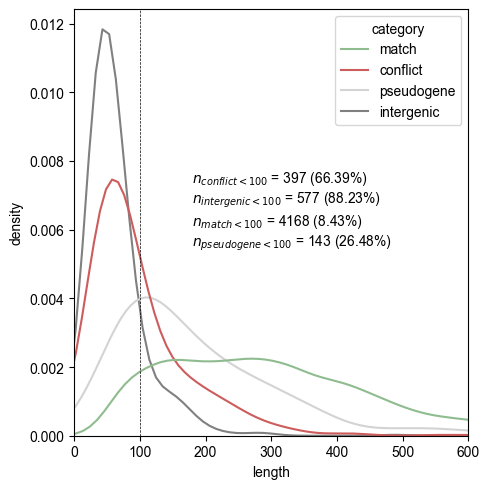

In [ ]:

def figure(dataset_df:pd.DataFrame):

    fig, ax = plt.subplots(figsize=(5, 5))

    palette = {'match':'darkseagreen', 'pseudogene':'lightgray', 'intergenic':'gray', 'conflict':'indianred'}


    ax_b_df = dataset_df.copy()

    sns.kdeplot(data=dataset_df, ax=ax, x='length', hue='category', palette=palette, common_norm=False)
    ax.set_ylabel('density')
    ax.set_xlim(xmin=0, xmax=600)

    text = ''
    for category, df in ax_b_df.groupby('category'):
        text += get_text(f'{category} < 100', (df.length < 100).sum(), len(df))
    ax.text(0.3, 0.4, text, transform=ax.transAxes, ha='left')
    sns.move_legend(ax, loc='upper right')
    ax.axvline(x=100, ls='--', lw=0.5, color='black')

    fig.tight_layout()
    plt.show()

figure(dataset_df)


In [31]:
def si_table_1(dataset_df:pd.DataFrame):

    table_df = pd.DataFrame(index=dataset_df.genome_id.unique())
    table_df['phylum'] = dataset_df.groupby('genome_id').phylum.first()
    table_df['gc_percent'] = dataset_df.groupby('genome_id').gc_percent.first()
    table_df['genome_size'] = dataset_df.groupby('genome_id').apply(len, include_groups=False)
    table_df['n_matches'] = dataset_df.groupby('genome_id').match.sum()
    table_df['n_hypothetical_matches'] = dataset_df.groupby('genome_id').apply(lambda df : ((df.top_hit_product == 'hypothetical protein') & df.match).sum(), include_groups=False)
    table_df['n_exact_matches'] = dataset_df.groupby('genome_id').exact_match.sum()
    table_df['n_extended'] = dataset_df.groupby('genome_id').extended.sum()
    table_df['n_truncated'] = dataset_df.groupby('genome_id').truncated.sum()
    table_df['n_pseudogenes'] = dataset_df.groupby('genome_id').pseudogene.sum()
    table_df['n_conflicts'] = dataset_df.groupby('genome_id').conflict.sum()
    table_df['n_intergenic'] = dataset_df.groupby('genome_id').intergenic.sum()

    totals = table_df.drop(columns=['gc_percent', 'phylum']).sum(axis=0)
    for col in [col for col in totals.index if col.startswith('n_')]:
        print(col.replace('n_', '', count=1), get_percent(totals.loc[col], totals.genome_size), f'(n={totals.loc[col]})')

    for col in [col for col in table_df.columns if col.startswith('n_')]:
        table_df[col.replace('n_', '', count=1)] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df[col], table_df.genome_size)]

    table_df = table_df.sort_values('gc_percent')
    table_df.index = table_df.index.map(dataset_df.groupby('genome_id').species.first())

    return table_df.drop(columns=[col for col in table_df.columns if col.startswith('n_')])


si_table_1(dataset_df)

matches 96.50% (n=49418)
hypothetical_matches 15.34% (n=7855)
exact_matches 85.67% (n=43874)
extended 6.37% (n=3264)
truncated 4.42% (n=2262)
pseudogenes 1.05% (n=540)
conflicts 1.17% (n=598)
intergenic 1.28% (n=654)


,phylum,gc_percent,genome_size,matches,hypothetical_matches,exact_matches,extended,truncated,pseudogenes,conflicts,intergenic
Clostridium sardiniense,Bacillota,28.5,3761,3683 (97.93%),587 (15.61%),3493 (92.87%),133 (3.54%),56 (1.49%),25 (0.66%),11 (0.29%),42 (1.12%)
Thermodesulfobium narugense,Thermodesulfobiota,34.0,1859,1828 (98.33%),192 (10.33%),1638 (88.11%),97 (5.22%),92 (4.95%),15 (0.81%),11 (0.59%),5 (0.27%)
Caldisericum exile,Caldisericota,35.5,1515,1497 (98.81%),174 (11.49%),1393 (91.95%),69 (4.55%),35 (2.31%),6 (0.40%),7 (0.46%),5 (0.33%)
Candidatus Thermokryptus mobilis,Candidatus Kryptoniota,38.5,2270,2215 (97.58%),258 (11.37%),1999 (88.06%),133 (5.86%),81 (3.57%),25 (1.10%),15 (0.66%),15 (0.66%)
Atribacter laminatus,Atribacterota,38.5,2760,2683 (97.21%),301 (10.91%),2436 (88.26%),148 (5.36%),97 (3.51%),20 (0.72%),16 (0.58%),41 (1.49%)
Limnoraphis robusta,Cyanobacteriota,42.0,5991,5742 (95.84%),1083 (18.08%),5167 (86.25%),390 (6.51%),184 (3.07%),104 (1.74%),64 (1.07%),81 (1.35%)
Fodinibius halophilus,Balneolota,42.5,3698,3549 (95.97%),649 (17.55%),3209 (86.78%),204 (5.52%),135 (3.65%),21 (0.57%),25 (0.68%),103 (2.79%)
Caldithrix abyssi,Calditrichota,45.0,3798,3714 (97.79%),530 (13.95%),3382 (89.05%),172 (4.53%),159 (4.19%),12 (0.32%),29 (0.76%),43 (1.13%)
Fidelibacter multiformis,Fidelibacterota,45.5,2290,2244 (97.99%),341 (14.89%),1982 (86.55%),145 (6.33%),117 (5.11%),6 (0.26%),19 (0.83%),21 (0.92%)
Candidatus Fervidibacter sacchari,Candidatus Fervidibacterota,51.5,3612,3461 (95.82%),719 (19.91%),2926 (81.01%),232 (6.42%),302 (8.36%),16 (0.44%),84 (2.33%),51 (1.41%)


In [50]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)

dataset_df = annotate(dataset_df)
dataset_df['top_hit_hypothetical'] = dataset_df.top_hit_product == 'hypothetical protein'
# Make sure these are in units of amino acids. 
dataset_df['query_length'] = dataset_df.seq.apply(len)
dataset_df['top_hit_length'] = dataset_df.top_hit_seq.apply(len)
dataset_df = has_alignment(dataset_df)

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

In [36]:
interpro_df = pd.concat([InterProScanFile(path).to_df() for path in glob.glob('../data/interpro/*')])
ids_with_antifam_hit = interpro_df[interpro_df.interpro_analysis == 'AntiFam'].index.unique()
ids_with_antifam_hit = np.intersect1d(ids_with_antifam_hit, dataset_df.index) # Make sure to remove AntiFam hits from the excluded genomes.
dataset_df['antifam_hit'] = dataset_df.index.isin(ids_with_antifam_hit)

antifam_interpro_df = interpro_df.loc[ids_with_antifam_hit].sort_values('interpro_e_value')
antifam_interpro_df = antifam_interpro_df[~antifam_interpro_df.index.duplicated(keep='first')].copy()

print('Num. proteins with AntiFam hit:', len(ids_with_antifam_hit))
for description, df in antifam_interpro_df.groupby('interpro_signature_description'):
    description = description[0].lower() + description[1:]
    print(f'\tNum. {description}:', len(df))

Num. proteins with AntiFam hit: 27
	Num. antisense to 23S rRNA: 5
	Num. antisense to RNaseP: 2
	Num. translation of CRISPR region: 9
	Num. tRNA translation: 11


In [52]:
results_df = pd.read_csv('../data/results/results-2/dataset_predict.csv', index_col=0)
results_df = results_df.merge(dataset_df, left_index=True, right_index=True, how='inner')
results_df = apply_thresholds(results_df, real_threshold=0.8, spurious_threshold=0.9)

top_hit_results_df = pd.read_csv('../data/results/results-2/top_hits_predict.csv', index_col=0)
top_hit_results_df = apply_thresholds(top_hit_results_df, real_threshold=0.8, spurious_threshold=0.9)
top_hit_results_df = top_hit_results_df[~top_hit_results_df.index.duplicated(keep='first')].copy()

with pd.option_context('future.no_silent_downcasting', True):
    for col in ['real', 'spurious', 'model_output_1', 'model_output_0', 'uncertain', 'model_label']:
        results_df[f'top_hit_{col}'] = results_df.top_hit_protein_id.map(top_hit_results_df[col])

In [38]:
print('Num. spurious:', results_df.spurious.sum(), f'({get_percent(results_df.spurious.sum(), len(results_df))})')
print('Num. uncertain:', results_df.uncertain.sum(), f'({get_percent(results_df.uncertain.sum(), len(results_df))})')
print('Num. real:', results_df.real.sum(), f'({get_percent(results_df.real.sum(), len(results_df))})')

Num. spurious: 1012 (1.98%)
Num. uncertain: 467 (0.91%)
Num. real: 49731 (97.11%)


figure: Num. real hypothetical matches: 7335 (93.38%)
figure: Num. hypothetical matches with a SwissProt homolog: 360 (4.58%)
figure: Num. real hypothetical matches with a SwissProt homolog: 351 (97.50%)


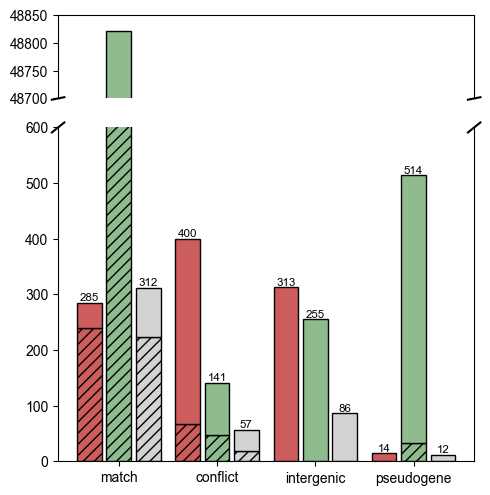

In [53]:
def figure(results_df:pd.DataFrame):

    fig, (ax_top, ax_bottom) = get_split_axes((0, 600), (48700, 48850))

    n_real_hypothetical_match = (is_top_hit_hypothetical(results_df) & results_df.real & results_df.match).sum()
    n_aligned_hypothetical_match = (is_top_hit_hypothetical(results_df) & results_df.aligned & results_df.match).sum()
    n_real_aligned_hypothetical_match = (is_top_hit_hypothetical(results_df) & results_df.aligned & results_df.match & results_df.real).sum()
    n_hypothetical_match = (is_top_hit_hypothetical(results_df) & results_df.match).sum()
    print('figure: Num. real hypothetical matches:', n_real_hypothetical_match, f'({get_percent(n_real_hypothetical_match, n_hypothetical_match)})')
    print('figure: Num. hypothetical matches with a SwissProt homolog:', n_aligned_hypothetical_match, f'({get_percent(n_aligned_hypothetical_match, n_hypothetical_match)})')
    print('figure: Num. real hypothetical matches with a SwissProt homolog:', n_real_aligned_hypothetical_match, f'({get_percent(n_real_aligned_hypothetical_match, n_aligned_hypothetical_match)})')

    figure_df = results_df.copy()
    figure_df['category'] = np.select([results_df.match, results_df.pseudogene, results_df.intergenic, results_df.conflict], ['match', 'pseudogene', 'intergenic', 'conflict'], default='none')
    categories = ['match', 'conflict', 'intergenic', 'pseudogene']
    figure_df['category'] = pd.Categorical(figure_df.category, categories, ordered=True)

    width = 0.25
    offsets = {'spurious':-0.3, 'real':0, 'uncertain':0.3}
    palette = {'spurious':'indianred', 'real':'darkseagreen', 'uncertain':'lightgray'}

    for model_label, df in figure_df.groupby('model_label'):
        ax_df = pd.DataFrame(index=categories)
        ax_df['total'] = df.category.value_counts()
        ax_df['fraction'] = df.groupby('category', observed=True).apply(lambda df : df.top_hit_unsupported.sum() / len(df), include_groups=False)
        ax_df['unsupported'] = ax_df['total'] * ax_df['fraction']
        ax_df['confirmed'] = ax_df['total'] * (1 - ax_df['fraction'])

        positions = np.arange(df.category.nunique())
        ax_top.bar(positions + offsets[model_label], ax_df.unsupported, color=palette[model_label], edgecolor='black', hatch='///', width=width)
        ax_top.bar(positions + offsets[model_label], ax_df.confirmed, bottom=ax_df.unsupported, color=palette[model_label], edgecolor='black', width=width)
        ax_bottom.bar(positions + offsets[model_label], ax_df.unsupported, color=palette[model_label], edgecolor='black', hatch='///', width=width)
        ax_bottom.bar(positions + offsets[model_label], ax_df.confirmed, bottom=ax_df.unsupported, color=palette[model_label], edgecolor='black', width=width)

        for x, total in zip(positions + offsets[model_label], ax_df.total):
            if total < 600:
                ax_bottom.text(x, total, str(total), ha='center', fontsize='small', va='bottom')
        ax_bottom.set_xticks(np.arange(4), ax_df.index)

    fig.tight_layout()


    plt.show()

figure(results_df)